In [1]:
using Turing
using DataFrames
using CSV
using Random
using StatisticalRethinking
using StatisticalRethinkingPlots
using StatsPlots
using StatsBase
using FreqTables
using Logging

default(label=false)
Logging.disable_logging(Logging.Warn);

# 11.1 Binomial regression

Code 11.1

In [2]:
d = DataFrame(CSV.File("data/chimpanzees.csv", delim=';'));

Code 11.2

In [3]:
d[!,:treatment] = 1 .+ d.prosoc_left .+ 2*d.condition;

Code 11.3

In [4]:
println(freqtable(d, :treatment, :prosoc_left, subset=d.condition .== 0))
println(freqtable(d, :treatment, :prosoc_left, subset=d.condition .== 1))

2×2 Named Matrix{Int64}
treatment ╲ prosoc_left │   0    1
────────────────────────┼─────────
1                       │ 126    0
2                       │   0  126
2×2 Named Matrix{Int64}
treatment ╲ prosoc_left │   0    1
────────────────────────┼─────────
3                       │ 126    0
4                       │   0  126


Code 11.4

In [5]:
@model function m11_1(pulled_left)
    a ~ Normal(0, 10)
    p = logistic(a)     # inverse of the `logit` function
    pulled_left ~ Binomial(1, p)
end

m11_1 (generic function with 2 methods)

Code 11.5

In [6]:
Random.seed!(1999)
prior_chain = sample(m11_1(d.pulled_left), Prior(), 10000)
prior = DataFrame(prior_chain);

Code 11.6

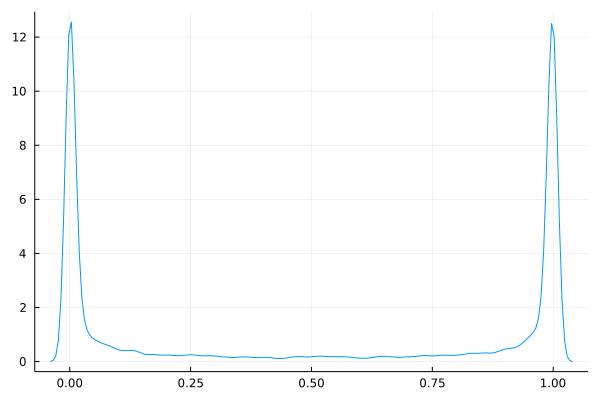

In [7]:
p = logistic.(prior.a)
density(p, bandwidth=0.01)

Code 11.7

In [8]:
@model function m11_2(pulled_left, treatment)
    a ~ Normal(0, 1.5)
    treat_levels = length(levels(d.treatment))
    b ~ MvNormal(zeros(treat_levels), 10)
    
    p = @. logistic(a + b[treatment])
    for i ∈ eachindex(pulled_left)
        pulled_left[i] ~ Binomial(1, p[i])
    end
end

Random.seed!(1999)
prior_chain = sample(m11_2(d.pulled_left, d.treatment), Prior(), 10000)
prior = DataFrame(prior_chain);

f = i -> @. logistic(prior.a + prior[!,"b[$i]"])
p = map(f, 1:4);

Code 11.8

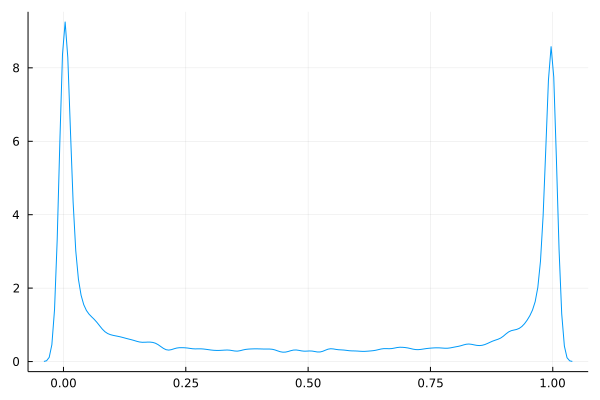

In [9]:
density(abs.(p[1] .- p[2]), bandwidth=0.01)

Code 11.9

In [10]:
@model function m11_3(pulled_left, treatment)
    a ~ Normal(0, 1.5)
    treat_levels = length(levels(treatment))
    b ~ MvNormal(zeros(treat_levels), 0.5)
    
    p = @. logistic(a + b[treatment])
    for i ∈ eachindex(pulled_left)
        pulled_left[i] ~ Binomial(1, p[i])
    end
end

Random.seed!(1999)
prior_chain = sample(m11_3(d.pulled_left, d.treatment), Prior(), 10000)
prior = DataFrame(prior_chain);

f = i -> @. logistic(prior.a + prior[!,"b[$i]"])
p = map(f, 1:4);

mean(abs.(p[1] .- p[2]))

0.09924607142428958

Code 11.10

In [11]:
dat_list = d[!,[:pulled_left, :actor, :treatment]];

Code 11.11

In [12]:
@model function m11_4(actor, treatment, pulled_left)
    act_levels = length(levels(actor))
    a ~ MvNormal(zeros(act_levels), 1.5)
    treat_levels = length(levels(treatment))
    b ~ MvNormal(zeros(treat_levels), 0.5)
    
    p = @. logistic(a[actor] + b[treatment])
    for i ∈ eachindex(pulled_left)
        pulled_left[i] ~ Binomial(1, p[i])
    end
end

m11_4_chain = sample(m11_4(dat_list.actor, dat_list.treatment, dat_list.pulled_left), NUTS(), 1000)
m11_4_df = DataFrame(m11_4_chain)
precis(m11_4_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│  a[1] │  -0.457  0.3381  -0.9885  -0.4566   0.0777  ▁▁▁▁▂▄▇█▇▆▂▁▁▁ │
│  a[2] │  3.8942   0.775   2.7576   3.8283   5.1935   ▁▁▄▇█▇▅▂▁▁▁▁▁ │
│  a[3] │  -0.752  0.3455  -1.2995  -0.7384  -0.2267    ▁▁▁▃▆███▅▂▁▁ │
│  a[4] │ -0.7477  0.3435   -1.303  -0.7393  -0.2006    ▁▁▁▃▅██▆▄▂▁▁ │
│  a[5] │ -0.4456  0.3427  -0.9981  -0.4388   0.0985    ▁▁▁▂▄▅█▇▆▂▁▁ │
│  a[6] │  0.4896  0.3515  -0.0806   0.4863    1.042   ▁▁▁▃▄███▄▂▁▁▁ │
│  a[7] │  1.9586  0.4169   1.3324   1.9373   2.6741   ▁▁▃▆███▇▄▃▁▁▁ │
│  b[1] │ -0.0421  0.2943  -0.4934  -0.0546   0.4495     ▁▁▄▆█▇▄▂▁▁▁ │
│  b[2] │  0.4819  0.2986   0.0119   0.4772    0.949      ▁▂▅▇█▇▄▂▁▁ │
│  b[3] │ -0.3816  0.2945  -0.8235  -0.3971   0.1029     ▁▁▁▂▆██▅▃▁▁ │
│  b[4] │  0.3715  0.2882  -0.0681   0.3632   0.8412     ▁▁▃▆██▅▂▁▁▁ │
└─────

Code 11.12

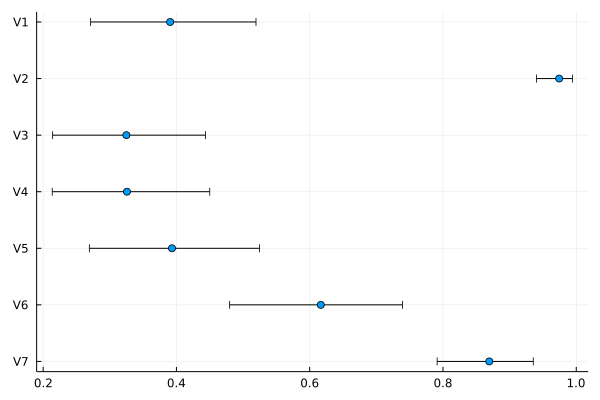

In [13]:
p_left = DataFrame(map(i -> "V$i" => logistic.(m11_4_df[:,"a[$i]"]), 1:7)...);
coeftab_plot(p_left)

Code 11.13

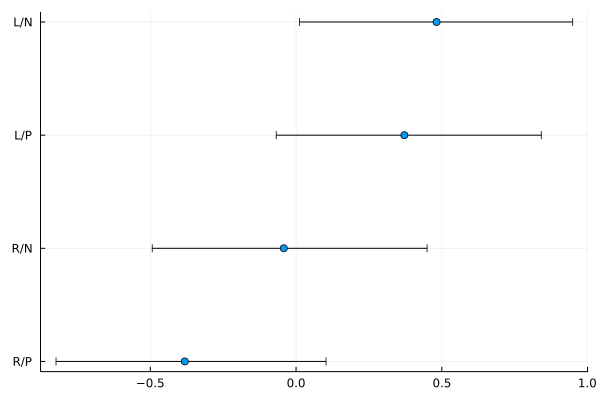

In [14]:
names = ["R/N", "L/N", "R/P", "L/P"]
labs = DataFrame(map(i -> names[i] => m11_4_df[:,"b[$i]"], 1:4)...)
coeftab_plot(labs)

Code 11.14

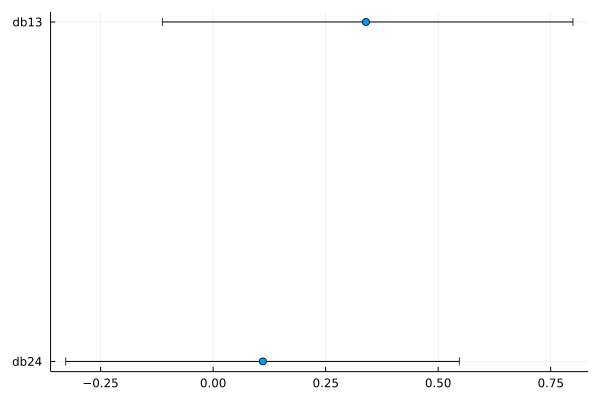

In [15]:
diffs = DataFrame(
    db13=m11_4_df."b[1]" .- m11_4_df."b[3]",
    db24=m11_4_df."b[2]" .- m11_4_df."b[4]",
)
coeftab_plot(diffs)

Code 11.15

In [16]:
gd = groupby(d, [:actor, :treatment])
c = combine(gd, :pulled_left => mean => :val)
pl = unstack(c, :actor, :treatment, :val)
pl[1,:]

,actor,1,2,3,4
,Int64,Float64?,Float64?,Float64?,Float64?
1,1,0.333333,0.5,0.277778,0.555556


Code 11.16

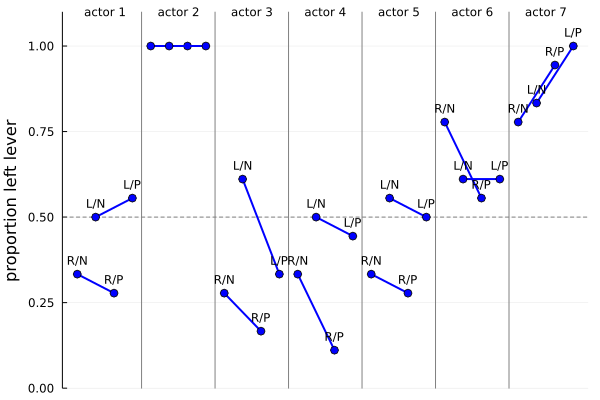

In [17]:
names = ["R/N", "L/N", "R/P", "L/P"]
p = plot(ylims=(0, 1.1), ylab="proportion left lever", showaxis=:y, xticks=false)
hline!([0.5], c=:gray, s=:dash)
for actor in 1:7
    ofs = (actor-1)*4
    actor > 1 && vline!([ofs+0.5], c=:gray)
    plot!([ofs+1,ofs+3], collect(pl[actor,["1","3"]]), lw=2, m=:o, c=:blue)
    plot!([ofs+2,ofs+4], collect(pl[actor,["2","4"]]), lw=2, m=:o, c=:blue)
    anns = [
        (ofs+idx, pl[actor,string(idx)]+.04, (name, 8))
        for (idx,name) ∈ enumerate(names)
    ]
    actor != 2 && annotate!(anns)
end

annotate!([
    (2.5 + (idx-1)*4, 1.1, ("actor $idx", 8))
    for idx ∈ 1:7
])
p